### prev_application 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가

#### 라이브러리 및 데이터 세트 로딩. 이전 application 데이터의 FE 함수 복사

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [4]:
app_test = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_test.csv')
app_train = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_train.csv')

In [5]:
def get_apps_dataset():
    app_test = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_test.csv')
    app_train = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/application_train.csv')
    apps = pd.concat([app_train, app_test])
    
    return apps

apps = get_apps_dataset()

#### 이전 application 데이터의 feature engineering 함수 복사

In [6]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

##### previous 데이터 로딩

In [8]:
prev = pd.read_csv('C:/Users/sw993/OneDrive/바탕 화면/ML/강의자료2/previous_application.csv')
print(prev.shape, apps.shape)

(1670214, 37) (356255, 122)


##### application와 previous outer 조인하고 누락된 집합들 확인. 

In [9]:
# previous와 applications를 양쪽 OUTER 조인하여 조인이 안되는 대상 조사
# pandas merge()시 인자로 indicator=True 부여하면 어느 집합이 조인에서 누락되는지 알수 있음. 
prev_app_outer =  prev.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True)
prev_app_outer['_merge'].value_counts()

both          1670214
right_only      17398
left_only           0
Name: _merge, dtype: int64

##### previous 컬럼과 Null 값 조사 

In [10]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### 주요 컬럼 EDA 수행

##### SK_ID_CURR당 평균 SK_ID_PREV 건수 구하기
* groupby 로 평균 건수 구함. 
* boxplot으로 시각화

In [11]:
# SK_ID_CURR 로 groupby하여 평균 건수 구함. 
prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count().mean()

4.928964135313716

C:\Users\sw993\anaconda3\envs\test1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SK_ID_CURR'>

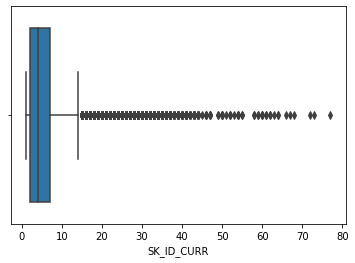

In [12]:
# box plot으로 시각화. 일부 데이터는 특정 SK_ID_CURR로 몇십개의 데이터가 있음. 
sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count())

#### 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

* application_train의 TARGET 값을 가져오기 위해 prev와 app_train을 inner join 후 TARGET 유형에 따라 비교
* 숫자형 컬럼명 필터링

In [13]:
# TARGET값을 application에서 가져오기 위해 조인. 
app_prev = prev.merge(app_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
app_prev.shape

(1670214, 38)

In [14]:
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')   

In [15]:
num_columns = app_prev.dtypes[app_prev.dtypes != 'object'].index.tolist()
num_columns = [column for column in num_columns if column not in['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
print(num_columns)

['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


C:\Users\sw993\anaconda3\envs\test1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sw993\anaconda3\envs\test1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sw993\anaconda3\envs\test1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

C:\Users\sw993\anaconda3\envs\test1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sw993\anaconda3\envs\test1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sw993\anaconda3\envs\test1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

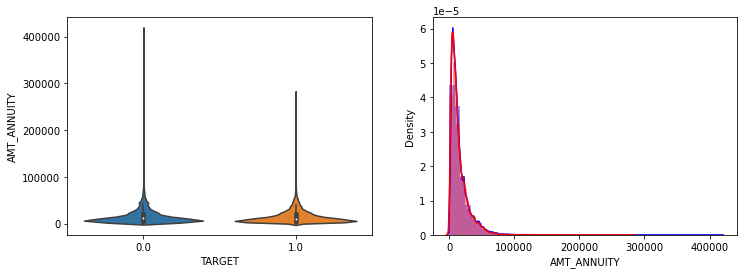

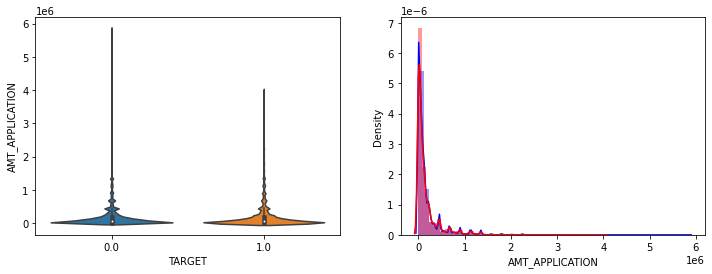

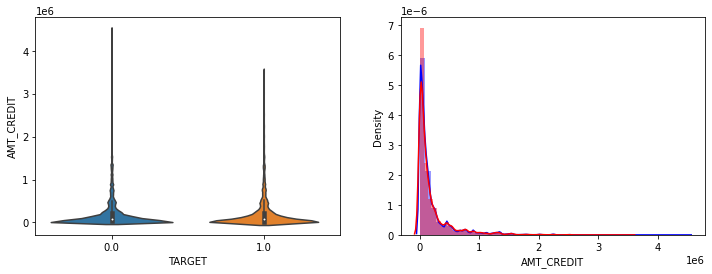

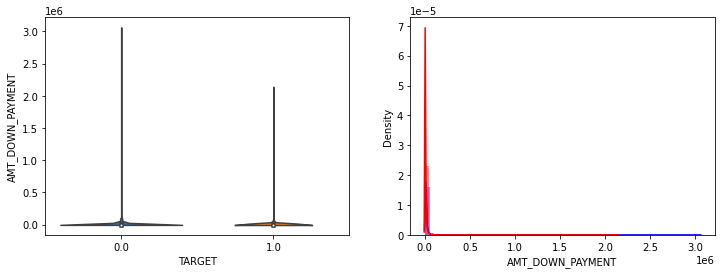

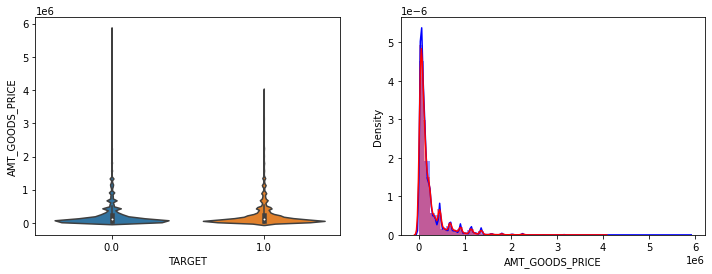

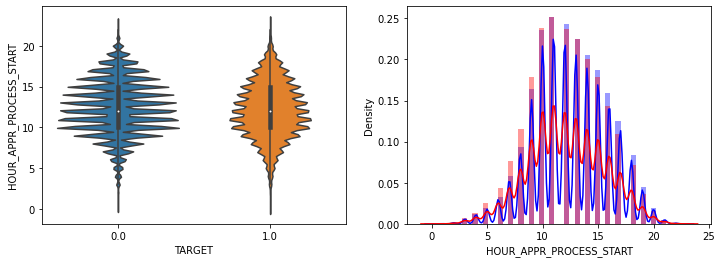

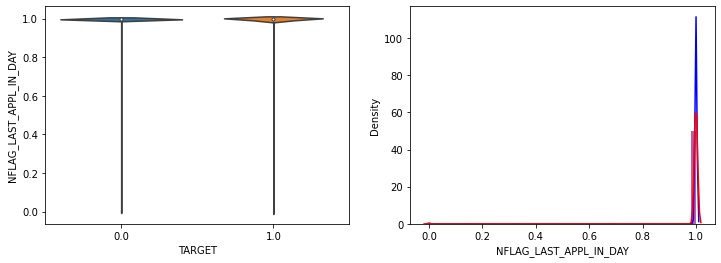

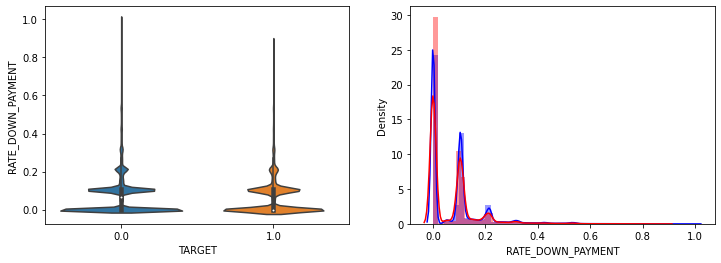

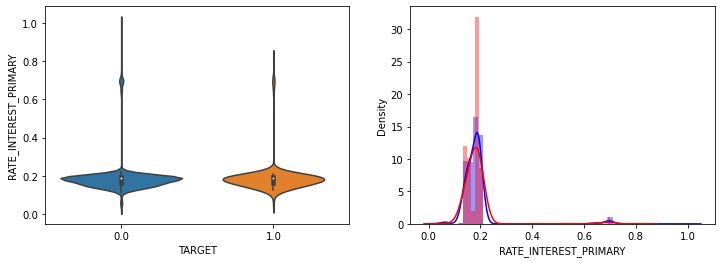

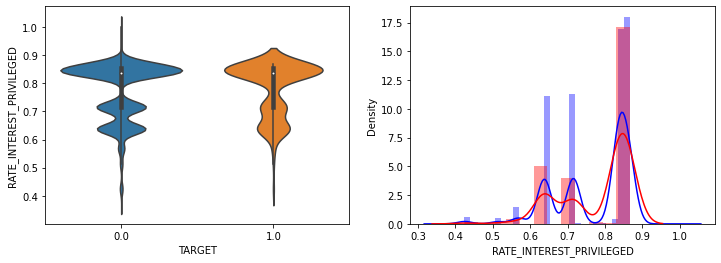

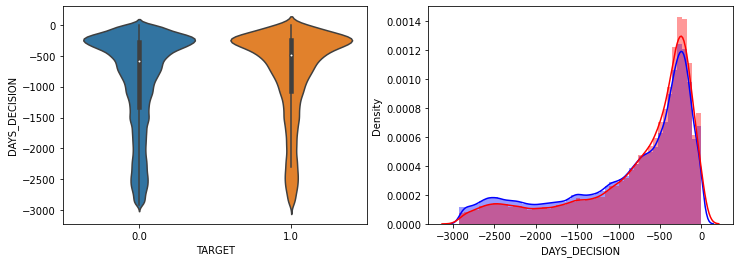

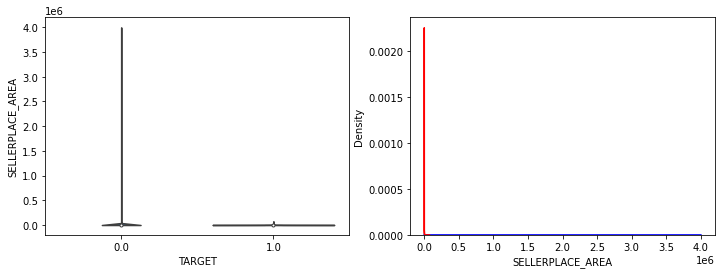

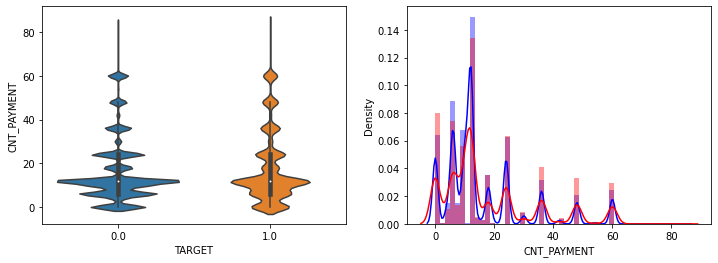

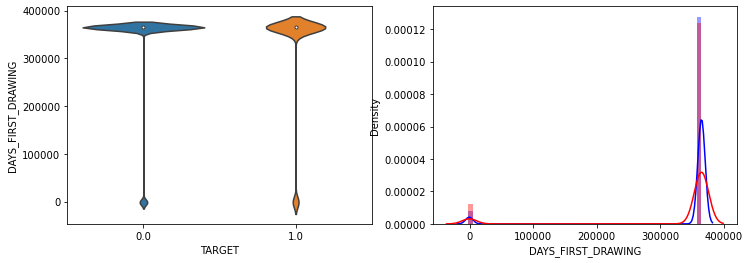

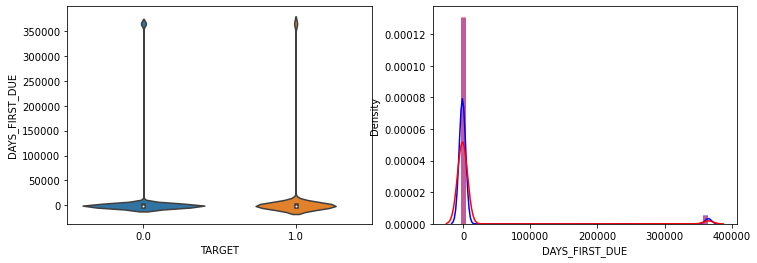

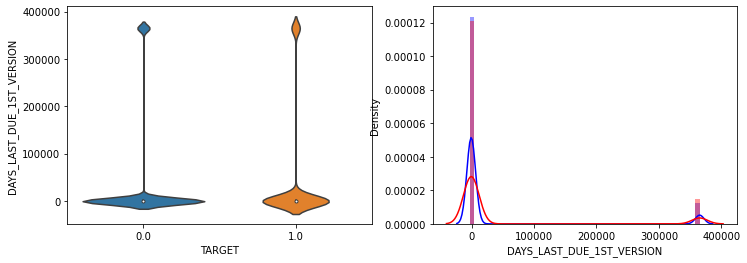

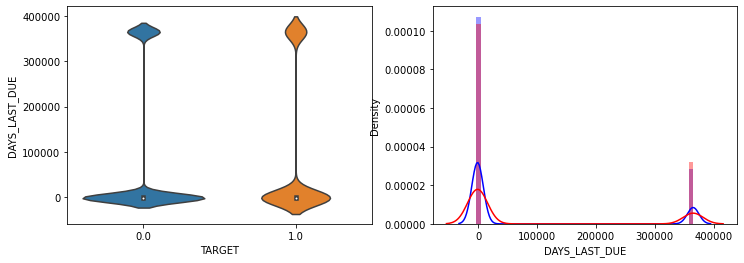

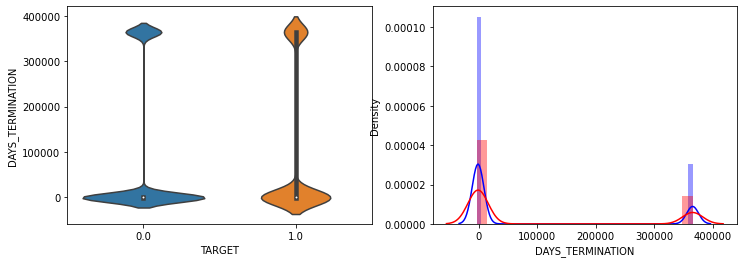

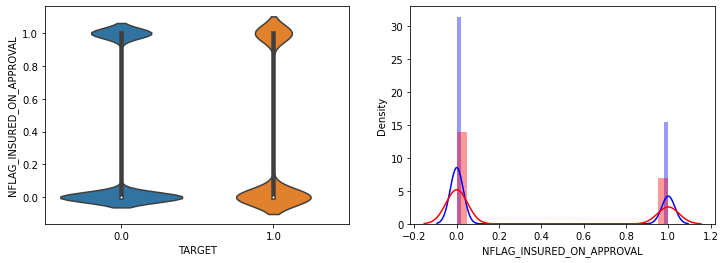

In [16]:
show_hist_by_target(app_prev, num_columns)

* AMT_ANNUITY, AMT_CREDIT, AMT_APPLICATION, AMT_GOODS_CREDIT는 TARGET=1일 경우에 소액 비율이 약간 높음(큰 차이는 아님)
* RATE_DOWN_PAYMENT는 큰 차이 없음. 
* RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED 는 NULL값이 매우 많아서 판단 어려움
* DAYS_DECISION은 TARGET=1일 때 0에 가까운(최근일)값이 약간 더 많음. 
* DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION은 365243 값이 매우 많음. 

#### Category 피처들의 Histogram을 TARGET 유형에 따라 비교

In [ ]:
object_columns = app_prev.dtypes[app_prev.dtypes=='object'].index.tolist()
object_columns

In [ ]:
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(app_prev, object_columns)

* NAME_CONTRACT_TYPE은 TARGET=1일때 CASH_LOAN의 비중이 약간 높음
* NAME_CONTRACT_STATUS(대출허가상태)는 TARGET=1일때 상대적으로 TARGET=0 대비 (당연히) Refused의 비율이 높음. 
* NAME_PAYMENT_TYPE(대출납부방법)는 TARGET=1일때 상대적으로 TARGET=0 대비 XNA의 비율이 약간 높음.

### prev 데이터 세트 feature engineering 수행. 
#### SQL 대비  Pandas groupby 사용 로직 비교

##### SQL로 SK_ID_CURR별 건수, 평균 AMT_CREDIT, 최대 AMT_CREDIT, 최소 AMT_CREDIT 구하기

In [ ]:
# select sk_id_curr, count(*), avg(amt_credit) , max(amt_credit), min(amt_credit) from previous group by sk_id_curr

##### pandas groupby 단일 aggregation 함수 사용
* groupby SK_ID_CURR
* SK_ID_CURR별 건수, AMT_CREDIT에 대한 평균, 최대 값

In [ ]:
prev.groupby('SK_ID_CURR')

In [ ]:
# DataFrameGroupby 생성. 
prev_group= prev.groupby('SK_ID_CURR')

# DataFrameGroupby 객체에 aggregation함수 수행 결과를 저장한 DataFrame 생성 및 aggregation값 저장. 
prev_agg = pd.DataFrame()
prev_agg['CNT'] = prev_group['SK_ID_CURR'].count()
prev_agg['AVG_CREDIT'] = prev_group['AMT_CREDIT'].mean()
prev_agg['MAX_CREDIT'] = prev_group['AMT_CREDIT'].max()

# groupby 컬럼값이 DataFrame의 Index가 됨. 컬럼으로 변환하려면 reset_index()로 변환 필요. 
prev_agg.head(10)

##### groupby agg()함수를 이용하여 여러개의 aggregation 함수 적용

In [ ]:
prev_group = prev.groupby('SK_ID_CURR')

# DataFrameGroupby의 agg() 함수를 이용하여 여러개의 aggregation 함수 적용
prev_agg1 = prev_group['AMT_CREDIT'].agg(['mean', 'max', 'sum'])
prev_agg2 = prev_group['AMT_ANNUITY'].agg(['mean', 'max', 'sum'])
# merge를 이용하여 두개의 DataFrame 결합. 
prev_agg = prev_agg1.merge(prev_agg2, on='SK_ID_CURR', how='inner')
prev_agg.head(10)

##### agg()에 dictionary를 이용하여 groupby 적용

In [ ]:
agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head()

##### grouby agg 로 만들어진  Multi index 컬럼 변경. 
* MultiIndex로 되어 있는 컬럼명 확인
* MultiIndex 컬럼명을 _로 연결하여 컬럼명 변경. 

In [ ]:
prev_amt_agg.columns

In [ ]:
# multi index 컬럼을 '_'로 연결하여 컬럼명 변경
prev_amt_agg.columns = ["PREV_"+"_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

In [ ]:
prev_amt_agg.head()

##### prev 피처 가공. 대출 신청액 대비 다른 금액 차이 및 비율 생성. 

In [ ]:
# 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

##### DAYS_XXX 피처의 365243 을 NULL로 변환하고, 첫번째 만기일과 마지막 만기일까지의 기간 가공

In [ ]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# 첫번째 만기일과 마지막 만기일까지의 기간
prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

##### 기존 이자율 관련 컬럼이 null이 많아서 새롭게 간단한 이자율을 대출 금액과 대출 금액 납부 횟수를 기반으로 계산 

In [ ]:
# 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
# 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']


In [ ]:
prev.iloc[:, -7:].head(10)

##### 기존 대출 금액, 대출 상태 관련 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행.

In [ ]:
# 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
agg_dict = {
     # 기존 컬럼. 
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    # 가공 컬럼
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE':['mean', 'max']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)

# multi index 컬럼을 '_'로 연결하여 컬럼명 변경
prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

In [ ]:
prev_amt_agg.head()

#### SK_ID_CURR별로 NAME_CONTRACT_STATUS가 Refused 일 경우의 건수 및 과거 대출건 대비 비율

#### Group by 기준  컬럼 기반에서 다른 컬럼들의 기준에 따라 세분화된 aggregation 수행. 

In [ ]:
prev['NAME_CONTRACT_STATUS'].value_counts()

##### SQL Group by Case when 과 pandas의 차이

In [ ]:
# SK_ID_CURR레벨로 groupby 된 count와  name_contract_status가 Refused일 때의 count 
'''select sk_id_curr, cnt_refused/cnt
from
(
    select sk_id_curr, count(*) cnt, count(case when name_contract_status == 'Refused' end) cnt_refused
    from previous group by sk_id_curr
) 
'''

##### Pandas는 원 DataFrame 에 groupby 적용된 DataFrame 과 세부기준으로 filtering 된 DataFrame에 groupby 적용된 DataFrame 을 조인하여 생성. 
* NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 및 filtering 된 DataFrame에 groupby 적용 
* groupby 완료 후 기존 prev_amt_agg와 조인
* 효율적인 오류 방지를 위해서 groupby 시 적용후 groupby key값을 DataFrame의 Index가 아닌 일반 컬럼으로 변경.

In [ ]:
# NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 
cond_refused = (prev['NAME_CONTRACT_STATUS'] == 'Refused')
prev_refused = prev[cond_refused]
prev_refused.shape, prev.shape

In [ ]:
# NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 된 DataFrame에 groupby 적용 
prev_refused_agg = prev_refused.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count()
print(prev_amt_agg.shape, prev_refused_agg .shape)
prev_refused_agg.head(10)

In [ ]:
# prev_refused_agg은 Series객체이고 Index는 SK_ID_CURR, prev_amt_agg은 DataFrame, Index는 SK_ID_CURR. 하지만 JOIN되지 않는다. 
# Series와 DataFrame 조인 시 Series를 DataFrame으로 내부 변환하는데 조인 시 Index명과 컬럼명이 서로 충돌하여 오류. 
prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')

In [ ]:
pd.DataFrame(prev_refused_agg)

In [ ]:
# 일반적으로 groupby key를 INDEX로 하는 것보다 일반 컬럼으로 하는 것이 여러가지 오류 예방에 효율적. 
prev_refused_agg = prev_refused_agg.reset_index(name='PREV_REFUSED_COUNT')
prev_amt_agg = prev_amt_agg.reset_index()

prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')
prev_amt_refused_agg.head()

##### 계산된 PREV_REFUSED_COUNT 중 Null값은 0 으로 변경하고 SK_ID_CURR 개별 건수 대비 PREV_REFUSED_COUNT 비율 계산

In [ ]:
prev_amt_refused_agg['PREV_REFUSED_COUNT'].value_counts(dropna=False)

In [ ]:
# REFUSED_COUNT가 NaN인 데이터는 과거 대출신청시 Refused가 없는 것임. 따라서 0으로 치환해야함. 
prev_amt_refused_agg['PREV_REFUSED_COUNT'] = prev_amt_refused_agg['PREV_REFUSED_COUNT'].fillna(0)
# SK_ID_CURR별 과거 대출건수 대비 REFUSED_COUNT 비율 생성. 
prev_amt_refused_agg['PREV_REFUSED_RATIO'] = prev_amt_refused_agg['PREV_REFUSED_COUNT']/prev_amt_refused_agg['PREV_SK_ID_CURR_COUNT']

In [ ]:
prev_amt_refused_agg.head(30)

##### 세부 레벨 groupby 와 unstack()을 이용하여 SQL Group by Case when 구현. 세부 조건이 2개 이상일때


###### SQL 일 경우
SELECT COUNT(CASE WHEN == 'Approved' END) , COUNT(CASE WHEN == 'Refused' END) FROM PREV GROUP BY SK_ID_CURR

##### Pandas로 수행.

In [ ]:
# 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
prev_refused_appr_agg.head(30)

In [ ]:
#prev_refu_appr_group['NAME_CONTRACT_STATUS'].count()
#prev_refu_appr_group['NAME_CONTRACT_STATUS'].count().unstack()

#####  컬럼명 변경, Null 처리, 그리고 기존의 prev_amt_agg와 조인 후 데이터 가공 

In [ ]:
# 컬럼명 변경. 
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
# NaN값은 모두 0으로 변경. 
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

In [ ]:
prev_refused_appr_agg.head()

In [ ]:
# prev_amt_agg와 조인. prev_amt_agg와 prev_refused_appr_agg 모두 SK_ID_CURR을 INDEX로 가지고 있음. 
prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
# SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
# 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
# prev_amt_agg와 prev_refused_appr_agg INDEX인 SK_ID_CURR이 조인 후 정식 컬럼으로 생성됨. 
prev_agg.head(30)

#### 가공된 최종 데이터 세트 생성
##### 이전에 application 데이터 세트의 feature engineering 수행 후 새롭게 previous 데이터 세트로 가공된 데이터를 조인. 

In [ ]:
apps_all =  get_apps_processed(apps)

In [ ]:
print(apps_all.shape, prev_agg.shape)
apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
print(apps_all.shape)

In [ ]:
apps_all.head()

In [ ]:
apps_all.info()

#### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음. 

In [ ]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
for column in object_columns:
    apps_all[column] = pd.factorize(apps_all[column])[0]

In [ ]:
apps_all.info()

#### 학습 데이터와 테스트 데이터 다시 분리

In [ ]:
apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
apps_all_test = apps_all[apps_all['TARGET'].isnull()]

apps_all_test = apps_all_test.drop('TARGET', axis=1)

In [ ]:
apps_all_train.columns.tolist()

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 

In [ ]:
from sklearn.model_selection import train_test_split

ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 50)

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit 수행. 

In [ ]:
preds = clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'prev_baseline_01.csv'), index=False)

#### 지금까지 만든 로직을 별도의 함수로 생성. 

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# 신청금액과 실제 대출액, 상품금액과의 차이 비율, 만기일 차이 비교, 이자율 계산등의 주요 컬럼 가공 생산. 
def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev

# 기존 컬럼및 위에서 가공된 신규 컬럼들에 대해서 SK_ID_CURR 레벨로 Aggregation 수행.  
def get_prev_amt_agg(prev):

    agg_dict = {
         # 기존 주요 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. . 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 신규 가공 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. .
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_amt_agg = prev_amt_agg.reset_index()
    
    return prev_amt_agg

# NAME_CONTRACT_STATUS의 SK_ID_CURR별 Approved, Refused의 건수 계산.  
def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
    
    return prev_refused_appr_agg

    
# 앞에서 구한 prev_amt_agg와 prev_refused_appr_agg를 조인하고 SK_ID_CURR별 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# apps와 previous 데이터 세트를 SK_ID_CURR레벨로 다양한 컬럼이 aggregation되어 있는 prev_agg 조인
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

# Label 인코딩 수행. 
def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

# 학습 데이터와 테스트 데이터 세트 분리. 
def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

# 학습 수행. 
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=32,
            subsample=0.8,
            max_depth=12,
            silent=-1,
            verbose=-1
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

##### 함수를 호출하여 재학습 및 평가 

In [ ]:
apps_all = get_apps_all_with_prev_agg(apps, prev)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
clf = train_apps_all(apps_all_train)


In [ ]:
preds = clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_01', index=False)